In [37]:
import torch
from transformers import CLIPModel, CLIPImageProcessor
import PIL
import torch.nn.functional as F
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [43]:
import torch
from transformers import CLIPModel, CLIPImageProcessor
import PIL
import torch.nn.functional as F

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

image1 = PIL.Image.open("google_images/google_31_0.jpg")
image2 = PIL.Image.open("google_images/google_31_90.jpg")
image3 = PIL.Image.open("google_images/google_23694_0.jpg")
image4 = PIL.Image.open("google_images/google_23694_270.jpg")

inputs1 = processor(images=image1, return_tensors="pt")
inputs2 = processor(images=image2, return_tensors="pt")
inputs3 = processor(images=image3, return_tensors="pt")
inputs4 = processor(images=image4, return_tensors="pt")
image_features1 = model.get_image_features(**inputs1)
image_features2 = model.get_image_features(**inputs2)
image_features3 = model.get_image_features(**inputs3)
image_features4 = model.get_image_features(**inputs4)


In [45]:
# Normalize the image features
image_features1_normalized = F.normalize(image_features1, p=2, dim=-1)
image_features2_normalized = F.normalize(image_features2, p=2, dim=-1)
image_features3_normalized = F.normalize(image_features3, p=2, dim=-1)
image_features4_normalized = F.normalize(image_features4, p=2, dim=-1)

# Compute cosine similarity between the two sets of image features
similarity12 = (image_features1_normalized @ image_features2_normalized.T).mean()
similarity13 = (image_features1_normalized @ image_features3_normalized.T).mean()
similarity14 = (image_features1_normalized @ image_features4_normalized.T).mean()
similarity23 = (image_features2_normalized @ image_features3_normalized.T).mean()
similarity24 = (image_features2_normalized @ image_features4_normalized.T).mean()
similarity34 = (image_features3_normalized @ image_features4_normalized.T).mean()

print(similarity12)
print(similarity13)
print(similarity14)
print(similarity23)
print(similarity24)
print(similarity34)

tensor(0.8934, grad_fn=<MeanBackward0>)
tensor(0.6818, grad_fn=<MeanBackward0>)
tensor(0.6703, grad_fn=<MeanBackward0>)
tensor(0.5920, grad_fn=<MeanBackward0>)
tensor(0.6241, grad_fn=<MeanBackward0>)
tensor(0.7752, grad_fn=<MeanBackward0>)


In [14]:
import cv2
import numpy as np
import os

# Load the images
files = os.listdir('google_images')

pano_path = "google_images/pano_images"

# get indices from file names
indices = []
for file in files:
    if file.endswith('.jpg'):
        indices.append(int(file.split('_')[1]))

# remove duplicates
indices = list(set(indices))

for index in indices:
    # Create an empty list to store the images
    pano_images = []
    for i in range(0, 360, 90):
        img = cv2.imread(f'google_images/google_{index}_{i}.jpg')
        pano_images.append(img)

    # Stitch images horizontally
    pano_stitch = np.concatenate(pano_images, axis=1)

    # Save the stitched image
    file_name_pano = f'{pano_path}/{index}.jpg'
    cv2.imwrite(file_name_pano, pano_stitch)

In [12]:
import geopandas as gpd
import pandas as pd

regions_gdf = gpd.read_file('../data/gadm_gdf_zone_2.shp')
image_df = pd.read_csv('../data/concat_google_image_metadata.csv')
image_gdf = gpd.GeoDataFrame(image_df, geometry=gpd.points_from_xy(image_df.Longitude, image_df.Latitude))


In [248]:
polygons_data = regions_gdf[regions_gdf["COUNTRY"]=="UnitedStates"]

In [249]:
import geopandas as gpd
joined_gdf = gpd.sjoin(polygons_data, image_gdf, how='right', op='contains')
points_within_polygon = joined_gdf.groupby('index_left').size()
polygons_data['population'] = points_within_polygon
polygons_data['population'].fillna(0, inplace=True)
# polygons_data = polygons_data[['GID_3', 'geometry', 'population']]

c:\Users\Juliu\Desktop\Masters_Thesis\imbag\env\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Juliu\AppData\Local\Temp\ipykernel_2556\2074296136.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  joined_gdf = gpd.sjoin(polygons_data, image_gdf, how='right', op='contains')
c:\Users\Juliu\Desktop\Masters_Thesis\imbag\env\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [250]:
# Step 1: Identify Low Population Regions
def identify_low_population_regions(df, threshold):
    low_population_regions = df[df['population'] <= threshold]
    return low_population_regions


def top_k_closest(polygons_data, index, k=5):
    # Calculate centroid of the specified polygon
    centroid = polygons_data.at[index, 'geometry'].centroid
    
    # Calculate distances from centroid to centroids of all polygons
    distances = {}
    for i, row in polygons_data.iterrows():
        distances[i] = centroid.distance(row['geometry'].centroid)
    
    # Sort distances dictionary by values (distances) in ascending order
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    
    # Extract indices of the top k closest polygons (excluding the specified index itself)
    closest_indices = [i for i, _ in sorted_distances[1:k+1]]
    
    return closest_indices


# Step 2: Find Neighboring Regions
def find_neighboring_regions(df, low_population_region):
    # Filter out the low population region itself
    df_others = df[df.index != low_population_region.name]
    neighboring_regions = df_others[df_others['geometry'].intersects(low_population_region['geometry'])]

    if neighboring_regions.empty:
        # If no neighboring regions are found, find the top k closest regions
        print(low_population_region.name)
        closest_indices = top_k_closest(df, low_population_region.name)
        neighboring_regions = df_others.loc[closest_indices]

    # same_level_2_region = neighboring_regions['NAME_2'] == low_population_region['NAME_2']
    # if same_level_2_region.any():
    #     return neighboring_regions[same_level_2_region]
    # else:
    # Check if neighboring regions belong to the same Level 1 administrative region
    same_level_1_region = neighboring_regions['GID_1'] == low_population_region['GID_1']
    if same_level_1_region.any():
        return neighboring_regions[same_level_1_region]
    else:
        return neighboring_regions

# Step 3: Merge with Neighbors
def merge_with_neighbors(low_population_region, neighboring_region):
    merged_geometry = low_population_region['geometry']
    merged_population = low_population_region['population']

    merged_geometry = merged_geometry.union(neighboring_region['geometry'])
    merged_population += neighboring_region['population']
    
    return merged_geometry, merged_population

def find_best_match(low_population_region, neighboring_regions, threshold):
    # Find the neighboring region with the closest population to the low population region
    best_match = neighboring_regions.iloc[0]

    best_population_sum = low_population_region['population'] + best_match['population']

    reached_threshold = best_population_sum >= threshold

    if len(neighboring_regions) == 1:
        return best_match
    
    # print(neighboring_regions)
    for index, neighbor in neighboring_regions.iterrows():
        population_sum = low_population_region['population'] + neighbor['population']
        reached_threshold = best_population_sum >= threshold
        if reached_threshold:
            if (threshold - population_sum <= 0) and (population_sum < best_population_sum):
                best_match = neighbor
                best_population_sum = population_sum
        else:
            if (population_sum > best_population_sum):
                best_match = neighbor
                best_population_sum = population_sum
                reached_threshold = best_population_sum >= threshold

    return best_match

# Step 4: Consider Level 1 Region Constraint (Loosened)
def merge_regions(low_population_region, neighboring_regions, threshold):
    best_match = find_best_match(low_population_region, neighboring_regions, threshold)
    merged_geometry, merged_population = merge_with_neighbors(low_population_region, best_match)
    merged_neighbors = best_match
    return merged_geometry, merged_population, merged_neighbors

# Step 5: Iterative Convergence
def iterative_convergence(df, threshold):
    new_df = df.copy()  # Create a copy of the original dataframe

    while True:
        # Step 1: Identify Low Population Regions
        low_population_regions = identify_low_population_regions(new_df, threshold)
        if low_population_regions.empty:
            break

        for index, low_population_region in low_population_regions.iterrows():
            # Step 2: Find Neighboring Regions
            neighboring_regions = find_neighboring_regions(new_df, low_population_region)
            merged_geometry, merged_population, merged_neighbors = merge_regions(low_population_region, neighboring_regions, threshold)
            new_df.at[index, 'geometry'] = merged_geometry
            new_df.at[index, 'population'] = merged_population

            # Remove neighboring regions from dataframe
            new_df = new_df.drop(merged_neighbors.name)
            # new_df.plot()
            break

    return new_df


# Perform iterative convergence
result_df = iterative_convergence(polygons_data, 150)
# Display the resulting dataframe
# print(result_df)

31225
31225
31226
31701
31701
31701
31701
32376
32376
33031
34142


In [251]:
polygons_data['population'].value_counts()

population
4.0      734
0.0      641
8.0      547
12.0     379
16.0     245
20.0     150
24.0     108
28.0      90
32.0      52
36.0      40
40.0      33
44.0      26
48.0      23
52.0      13
60.0      13
56.0      10
72.0       6
64.0       5
92.0       5
68.0       4
116.0      3
88.0       3
80.0       3
84.0       2
124.0      1
120.0      1
112.0      1
108.0      1
212.0      1
152.0      1
200.0      1
76.0       1
180.0      1
720.0      1
100.0      1
264.0      1
192.0      1
Name: count, dtype: int64

In [252]:
result_df['population'].value_counts()

population
272.0    5
216.0    5
152.0    4
404.0    4
344.0    4
        ..
304.0    1
212.0    1
632.0    1
436.0    1
468.0    1
Name: count, Length: 62, dtype: int64

In [253]:
results_copy = result_df.copy()
# use buffer(0.5) and buffer(-0.5) to remove slivers
results_copy.crs = "EPSG:4326"
results_copy['geometry'] = results_copy.buffer(0.001).buffer(-0.001)

C:\Users\Juliu\AppData\Local\Temp\ipykernel_2556\304133030.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  results_copy['geometry'] = results_copy.buffer(0.001).buffer(-0.001)


<Axes: >

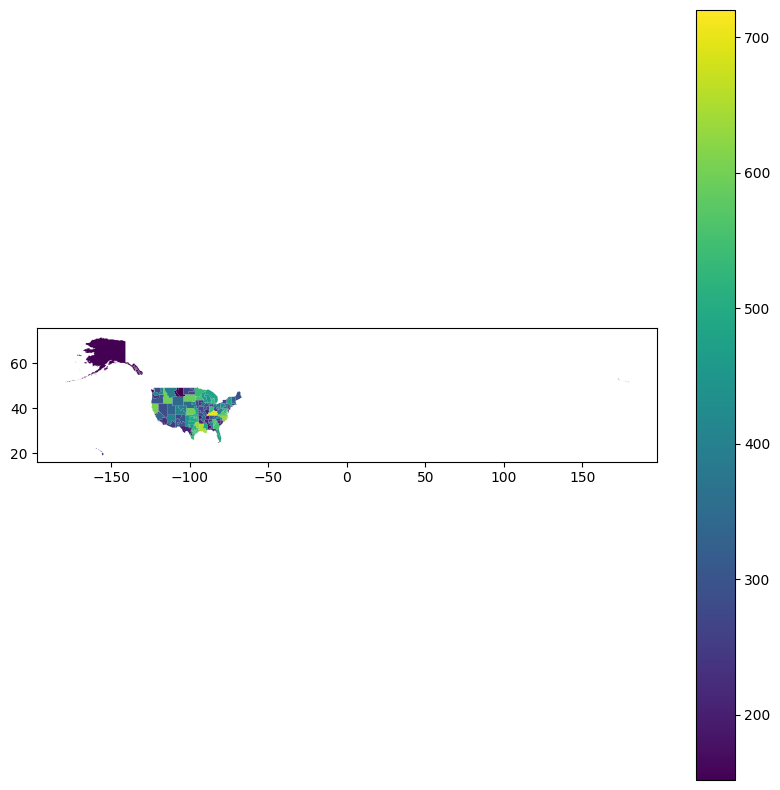

In [254]:
results_copy.plot(column='population', legend=True, figsize=(10, 10))

In [257]:
points_gdf = image_gdf[image_gdf['Country'] == 'United States']
points_gdf

,Index,Longitude,Latitude,Pano ID,Country,Region,Date,Climate Zone,geometry
24860,6221_0,-87.886968,32.839996,RyQc6OPPUdD-AyHg2PGbKg,United States,Alabama,2014-04,Cfa,POINT (-87.88697 32.84000)
24861,6221_90,-87.886968,32.839996,RyQc6OPPUdD-AyHg2PGbKg,United States,Alabama,2014-04,Cfa,POINT (-87.88697 32.84000)
24862,6221_180,-87.886968,32.839996,RyQc6OPPUdD-AyHg2PGbKg,United States,Alabama,2014-04,Cfa,POINT (-87.88697 32.84000)
24863,6221_270,-87.886968,32.839996,RyQc6OPPUdD-AyHg2PGbKg,United States,Alabama,2014-04,Cfa,POINT (-87.88697 32.84000)
24864,6222_0,-85.930024,31.820148,UfK68zm-HbpkXboTjkiErQ,United States,Alabama,2023-04,Cfa,POINT (-85.93002 31.82015)
...,...,...,...,...,...,...,...,...,...
333814,99541_270,-107.979978,44.254373,0agKc5w3klOSdFJ5prehkw,United States,Wyoming,2009-09,BWk,POINT (-107.97998 44.25437)
333815,99542_0,-104.735387,41.122890,LjuBnB5jc-LKPpaZK6PPlw,United States,Wyoming,2021-09,BSk,POINT (-104.73539 41.12289)
333816,99542_90,-104.735387,41.122890,LjuBnB5jc-LKPpaZK6PPlw,United States,Wyoming,2021-09,BSk,POINT (-104.73539 41.12289)
333817,99542_180,-104.735387,41.122890,LjuBnB5jc-LKPpaZK6PPlw,United States,Wyoming,2021-09,BSk,POINT (-104.73539 41.12289)


In [266]:
points_gdf.crs = "EPSG:4326"

In [258]:
points_gdf['GID_2'] = None

# Iterate over each polygon and check if each point falls within it
for index, polygon in results_copy.iterrows():
    # Use the 'contains' function to check if points are within the polygon
    points_within_polygon = points_gdf[points_gdf.geometry.within(polygon['geometry'])]
    # Update the 'polygon_id' column for the points within this polygon
    points_gdf.loc[points_within_polygon.index, 'GID_2'] = polygon['GID_2']  # Assuming you have a column 'polygon_id' in your gdf_polygons


c:\Users\Juliu\Desktop\Masters_Thesis\imbag\env\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [259]:
points_gdf = points_gdf.drop_duplicates(subset="geometry")

In [264]:
results_copy["GID_2"].value_counts()
results_copy.crs = "EPSG:4326"

In [261]:
from sklearn.cluster import OPTICS

# Initialize cluster label column with None
points_gdf['cluster_label'] = points_gdf["GID_2"]

for index, row in results_copy.iterrows():
    if row['population'] > 200:
        print(row['GID_2'])
        
        # Initialize OPTICS clustering
        optics = OPTICS(min_samples=20)
        
        # Filter points by region
        region_gdf = points_gdf[points_gdf['GID_2'] == row['GID_2']]
        
        # Fit OPTICS clustering
        points_gdf.loc[region_gdf.index, 'cluster_label'] = optics.fit_predict(region_gdf[['Longitude', 'Latitude']])
        
        # Add "_row['GID_2']" to the cluster label to make it unique
        points_gdf.loc[region_gdf.index, 'cluster_label'] = points_gdf.loc[region_gdf.index, 'cluster_label'].apply(lambda x: f"{x}_{row['GID_2']}")


c:\Users\Juliu\Desktop\Masters_Thesis\imbag\env\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


USA.1.57_1
USA.1.67_1
USA.3.7_1
USA.3.15_1
USA.4.71_1
USA.4.74_1
USA.4.75_1
USA.5.13_1
USA.5.42_1
USA.5.56_1
USA.5.58_1
USA.6.58_1
USA.6.62_1
USA.9.1_1
USA.10.60_1
USA.10.64_1
USA.10.67_1
USA.11.155_1
USA.11.159_1
USA.12.1_1
USA.13.41_1
USA.14.51_1
USA.14.98_1
USA.14.100_1
USA.14.103_1
USA.15.90_1
USA.15.93_1
USA.16.89_1
USA.16.97_1
USA.16.98_1
USA.17.102_1
USA.17.105_1
USA.18.120_1
USA.19.64_1
USA.20.15_1
USA.23.85_1
USA.23.86_1
USA.24.87_1
USA.24.88_1
USA.25.79_1
USA.25.81_1
USA.26.109_1
USA.26.111_1
USA.26.113_1
USA.26.114_1
USA.27.54_1
USA.28.90_1
USA.28.93_1
USA.29.15_1
USA.31.21_1
USA.32.30_1
USA.32.31_1
USA.32.33_1
USA.33.44_1
USA.33.59_1
USA.33.63_1
USA.34.94_1
USA.34.100_1
USA.35.48_1
USA.35.53_1
USA.36.83_1
USA.36.86_1
USA.36.89_1
USA.37.73_1
USA.37.74_1
USA.38.32_1
USA.38.36_1
USA.39.63_1
USA.39.66_1
USA.40.1_1
USA.40.3_1
USA.41.43_1
USA.41.44_1
USA.41.45_1
USA.42.66_1
USA.43.87_1
USA.43.95_1
USA.44.229_1
USA.44.234_1
USA.44.239_1
USA.44.251_1
USA.44.252_1
USA.44.253_1
USA.4

In [262]:
points_gdf['cluster_label'].value_counts()

cluster_label
0_USA.9.1_1       175
0_USA.44.229_1    140
0_USA.11.159_1    138
-1_USA.34.94_1    135
-1_USA.5.58_1     124
                 ... 
-1_USA.16.98_1      8
-1_USA.27.54_1      4
-1_USA.6.58_1       4
-1_USA.29.15_1      3
-1_USA.40.1_1       2
Name: count, Length: 183, dtype: int64

In [277]:
points_gdf["GID_2"].isna().sum()

3

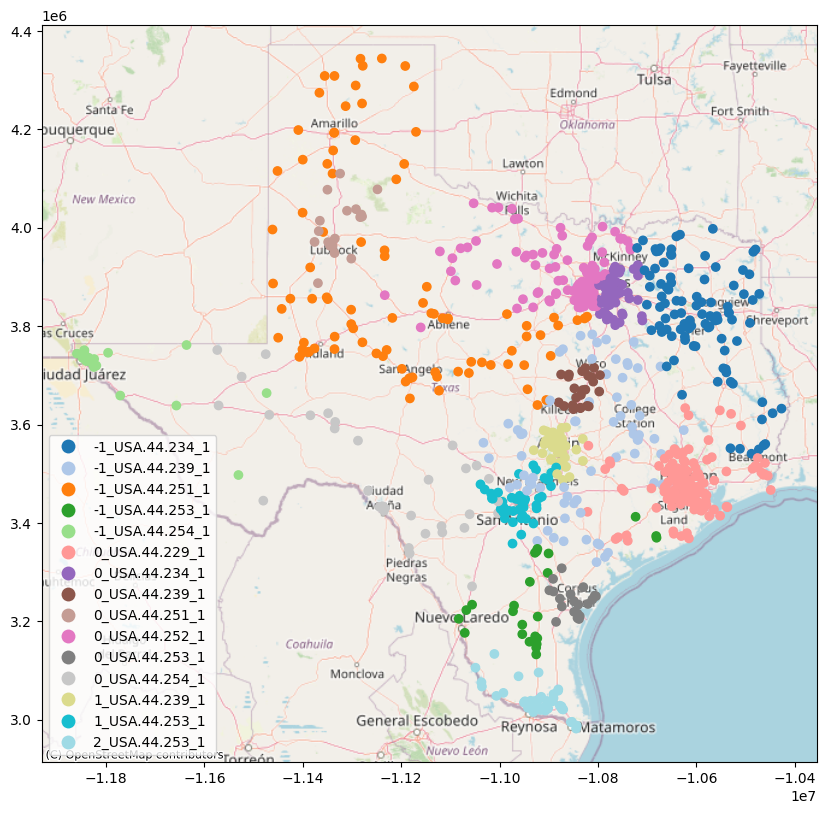

In [282]:
import contextily as ctx
import matplotlib.pyplot as plt

# Define a colormap
cmap = 'tab20'  # You can choose any colormap available in Matplotlib

results_copy = results_copy.to_crs(epsg=3857)
points_gdf = points_gdf.to_crs(epsg=3857)

# Plot the data with specified colormap
ax = results_copy.plot(figsize=(10, 10), alpha=0.2, edgecolor='k')
# Plot points with cluster labels using the specified colormap
points_gdf.dropna()[points_gdf.dropna()["GID_2"].str.contains("USA.44.")].plot(column='cluster_label', ax=ax, legend=True, figsize=(10, 10), cmap=cmap)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()


In [82]:
from ipyleaflet import GeoJSON, Map, basemaps
# display it in a map
m = Map(basemap=basemaps.Esri.WorldImagery, zoom=2, center=(39.8283, -98.5795))
m.add(GeoJSON(data=points_gdf[points_gdf["cluster_label"] == -1].__geo_interface__, style={"color": "red", "fillOpacity": .4}))
m.add(GeoJSON(data=points_gdf[points_gdf["cluster_label"] == 0].__geo_interface__, style={"color": "blue", "fillOpacity": .4}))
m.add(GeoJSON(data=points_gdf[points_gdf["cluster_label"] == 1].__geo_interface__, style={"color": "black", "fillOpacity": .4}))
m.add(GeoJSON(data=points_gdf[points_gdf["cluster_label"] == 2].__geo_interface__, style={"color": "yellow", "fillOpacity": .4}))

m

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [37]:
from ipyleaflet import GeoJSON, Map, basemaps
# display it in a map
m = Map(basemap=basemaps.Esri.WorldImagery, zoom=2, center=(39.8283, -98.5795))
m.add(GeoJSON(data=results_copy.__geo_interface__, style={"color": "red", "fillOpacity": .4}))

m

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [117]:
from scipy.spatial import Voronoi

# Extract point coordinates from the geodataframe
points = gdf_points.geometry.apply(lambda p: (p.x, p.y)).tolist()

# Perform Voronoi clustering
vor = Voronoi(points)

In [118]:
from shapely.geometry import Polygon

# Create polygons from Voronoi vertices
polygons = [Polygon(vor.vertices[region]) for region in vor.regions if -1 not in region]

# Create a GeoDataFrame for Voronoi polygons
gdf_voronoi = gpd.GeoDataFrame(geometry=polygons, crs=gdf_points.crs)


In [121]:
# Clip geocells to administrative boundaries
gdf_clipped = gpd.overlay(gdf_voronoi, polygons_data, how='intersection')

C:\Users\Juliu\AppData\Local\Temp\ipykernel_24128\2639624065.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_clipped = gpd.overlay(gdf_voronoi, polygons_data, how='intersection')


In [126]:
gdf_clipped

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,...,CC_1,HASC_1,ISO_1,VARNAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,population,geometry
0,ALB.2.1.1_1,ALB,Albania,ALB.2_1,Dibër,NA,ALB.2.1_1,Bulqizës,NA,Bulqizë,...,None,None,None,None,None,None,None,None,0.0,"POLYGON ((20.23320 41.45840, 20.21360 41.46490..."
1,ALB.2.1.2_1,ALB,Albania,ALB.2_1,Dibër,NA,ALB.2.1_1,Bulqizës,NA,FushëBulqizë,...,None,None,None,None,None,None,None,None,0.0,"POLYGON ((20.26100 41.46760, 20.26500 41.48310..."
2,ALB.2.1.3_1,ALB,Albania,ALB.2_1,Dibër,NA,ALB.2.1_1,Bulqizës,NA,Gjoricë,...,None,None,None,None,None,None,None,None,0.0,"POLYGON ((20.45168 41.47904, 20.44330 41.47360..."
3,ALB.2.1.4_1,ALB,Albania,ALB.2_1,Dibër,NA,ALB.2.1_1,Bulqizës,NA,Ostren,...,None,None,None,None,None,None,None,None,0.0,"POLYGON ((20.50983 41.39952, 20.50650 41.39300..."
4,ALB.2.1.5_1,ALB,Albania,ALB.2_1,Dibër,NA,ALB.2.1_1,Bulqizës,NA,Shupenzë,...,None,None,None,None,None,None,None,None,0.0,"POLYGON ((20.42036 41.52186, 20.41180 41.51160..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,ALB.11.2.14_1,ALB,Albania,ALB.11_1,Tiranë,NA,ALB.11.2_1,Tiranës,NA,Shëngjergj,...,None,None,None,None,None,None,None,None,0.0,"POLYGON ((20.07987 41.32492, 20.09705 41.27109..."
1030,ALB.4.1.4_1,ALB,Albania,ALB.4_1,Elbasan,NA,ALB.4.1_1,Elbasanit,NA,Elbasan,...,None,None,None,None,None,None,None,None,24.0,"POLYGON ((20.10872 41.11872, 20.10872 41.11877..."
1031,ALB.4.1.14_1,ALB,Albania,ALB.4_1,Elbasan,NA,ALB.4.1_1,Elbasanit,NA,LabinotFushë,...,None,None,None,None,None,None,None,None,8.0,"POLYGON ((20.11126 41.17547, 20.11280 41.17640..."
1032,ALB.4.1.15_1,ALB,Albania,ALB.4_1,Elbasan,NA,ALB.4.1_1,Elbasanit,NA,LabinotMal,...,None,None,None,None,None,None,None,None,0.0,"POLYGON ((20.11381 41.21856, 20.14579 41.16046..."
